# Space Partitioning

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import cm
import copy
import itertools
import nlopt

In [1053]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [1121]:
def fun(x):
    '''ring'''
    r = np.sqrt(np.sum(np.square(np.asarray(x) - 12), axis=0))
    return np.exp(-(r - 10)**2/30)

In [1155]:
def fun(x):
    '''eggbox'''
    return (2 + np.cos(x[0]/2) * np.cos(x[1]/2))**5

In [978]:
def fun(x):
    '''gaussian'''
    return np.exp(-((x[0] - 10)**2 + (x[1] - 15)**2)/100)

In [1041]:
def phi(d): 
    # Using the above nested radical formula for g=phi_d 
    # or you could just hard-code it. 
    # phi(1) = 1.61803398874989484820458683436563 
    # phi(2) = 1.32471795724474602596090885447809 

    x=2.0
    for i in range(10): 
        x = pow(1+x,1/(d+1)) 
    return x


def quasi_rand(ndim, nsamples):

    ''' from http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/
    
    ndim : number of dimesnions
    nsamples : number of samples
    
    '''


    g = phi(ndim) 
    alpha = np.zeros(ndim) 
    for j in range(ndim): 
        alpha[j] = pow(1 / g, j+1) % 1 
        
    sample = np.zeros((ndim, nsamples)) 

    # This number can be any real number. 
    # Common default setting is typically seed=0
    # But seed = 0.5 is generally better. 

    seed = 0.5

    for i in range(nsamples): 
        sample[:,i] = (seed + alpha * (i + 1)) % 1
        
    return sample

In [1156]:
bounds = np.array([[0, 36.], [3, 30.]])

In [1157]:
N = 300
xx, yy = np.meshgrid(np.linspace(*bounds[0],N), np.linspace(*bounds[1],N))

In [1158]:
f = fun([xx, yy])

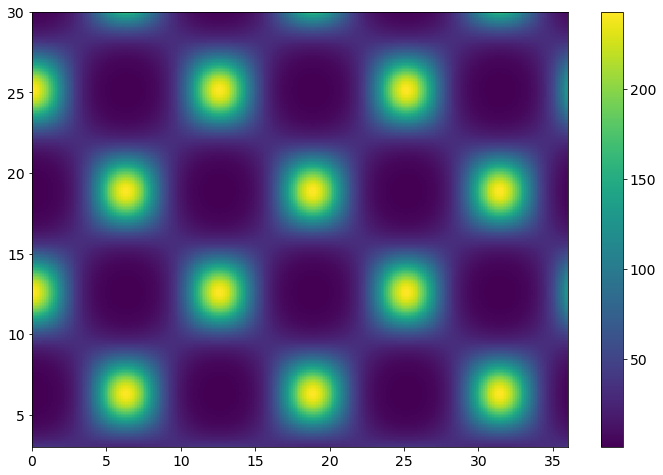

In [1159]:
pc = plt.pcolormesh(xx, yy, f)
plt.colorbar(pc)

In [1160]:
n_samples = 1000
#x = np.random.rand(2, n_samples)

x = quasi_rand(2, n_samples)


x[0] = x[0] * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
x[1] = x[1] * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
z = fun(x)

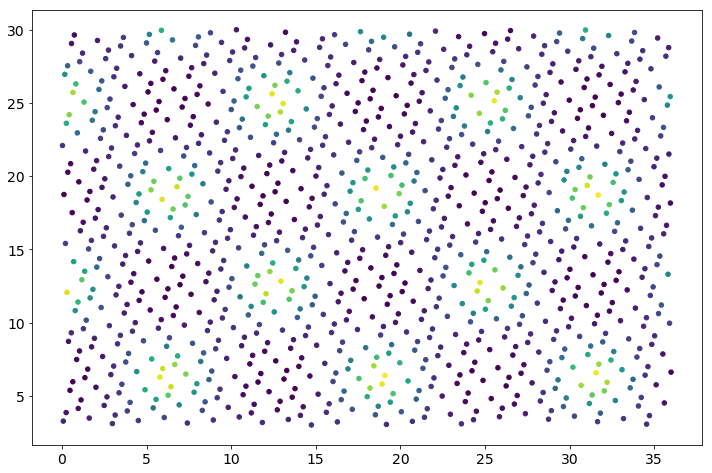

In [1167]:
plt.scatter(x[0],x[1],c=z, s=20)

In [1044]:
def metric(x, z):
    if len(z) == 0:
        return 1000
    #return np.var(z) * len(z)
    mean = np.average(x, axis=1) #weights=z
    return np.var(z) * len(z) #+ np.sum(np.sum((x - mean[:, np.newaxis])**2, axis=0))

In [909]:
metric(x,z)

34282977.67360254

In [910]:
def weighted_avg_and_var(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if len(values) == 0:
        return (0, 0)
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, variance)

In [729]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''

    mu_tot, var_tot = weighted_avg_and_var(x, z)
    
    mask = x < t
    
    mu_1, var_1 = weighted_avg_and_var(x[mask], z[mask])
    mu_2, var_2 = weighted_avg_and_var(x[~mask], z[~mask])
        
    return var_tot - 1/np.sum(z) * (np.sum(z[mask]) * var_1 + np.sum(z[~mask]) * var_2)

In [730]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''
    mask = x < t
    
    
    mu_1, var_1 = weighted_avg_and_var(x[mask], z[mask])
    mu_2, var_2 = weighted_avg_and_var(x[~mask], z[~mask])
        
    return np.sum(z[mask]) * np.sum(z[~mask]) * (mu_1 - mu_2)**2

In [807]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''
    mask = x < t
    
    
    var_1 = np.var(z[mask])
    var_2 = np.var(z[~mask])
    
    return np.sum(mask) * var_1 + np.sum(~mask) * var_2
    
    #mu_1, var_1 = weighted_avg_and_var(z[mask], z[mask])
    #mu_2, var_2 = weighted_avg_and_var(z[~mask], z[~mask])
        
    #return np.sum(z[mask]) * np.sum(z[~mask]) * (mu_1 - mu_2)**2

In [1170]:
dim = 0

x_cuts = np.linspace(*bounds[dim], 300)
vals = []
for x_cut in x_cuts:
    
    vals.append(between_class_var(x[dim], z, x_cut))
    
    #mask = x[0] < x_cut
    #vals.append(np.sqrt((metric(x[:,mask],z[mask]) + metric(x[:,~mask],z[~mask]))))

x_cuts[np.argmin(vals)]

0.0

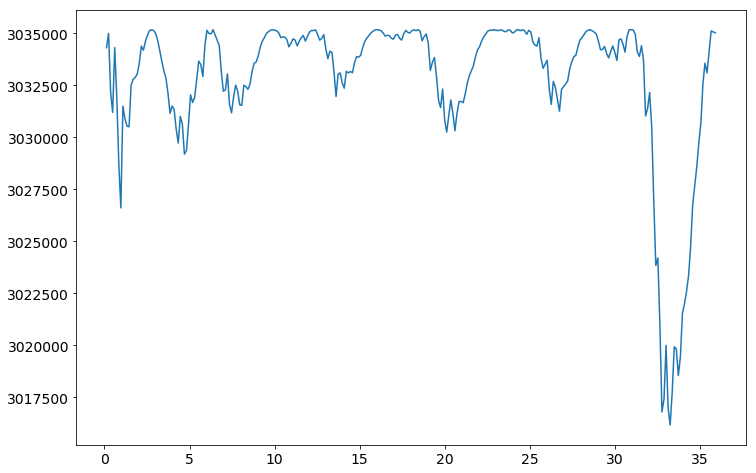

In [1171]:
plt.plot(x_cuts, vals)

In [825]:
class Node():
    def __init__(self, dim=0, val=0.5, terminal=False):
        self.dim = dim
        self.val = val
        self.terminal = terminal
        self.left = None
        self.right = None
        
    def __repr__(self):
        return str(self.rep)
        
    @property
    def rep(self):
        if self.terminal:
            return None
        return [self.dim, self.val, self.left.rep, self.right.rep]
        
    @property
    def type(self):
        if self.terminal:
            return 'T'
        return f'[{self.dim},{self.left.type},{self.right.type}]'
    
    @property
    def vals(self):
        '''get flat array of values
        '''
        if self.terminal:
            return []
        return [self.val] + self.left.vals + self.right.vals
        
    def set_vals(self, vals, idx=0):
        if self.terminal:
            return idx
        self.val = vals[idx]
        idx += 1
        idx = self.left.set_vals(vals, idx) 
        idx = self.right.set_vals(vals, idx) 
        return idx
        
    def cut_value(self, parent_bounds):
        return (1 - self.val) * parent_bounds[self.dim, 0] + self.val * parent_bounds[self.dim, 1]
        
    def eval(self, x, z, parent_bounds):
        if self.terminal:
            mask = np.ones_like(z).astype(np.bool)
            for dim in range(len(parent_bounds)):
                mask &= (x[dim] >= parent_bounds[dim][0]) & (x[dim] < parent_bounds[dim][1])
            return metric(x[:, mask], z[mask])
        else:
            bounds = self.bounds(parent_bounds)
            return self.left.eval(x, z, bounds[0]) + self.right.eval(x, z, bounds[1])
        
    def bounds(self, parent_bounds):
        if self.terminal:
            return parent_bounds
        bounds = [copy.deepcopy(parent_bounds), copy.deepcopy(parent_bounds)]
        cut = self.cut_value(parent_bounds)
        bounds[0][self.dim, 1] = cut
        bounds[1][self.dim, 0] = cut
        return bounds
        
    def recursive_bounds(self, parent_bounds):
        if self.terminal:
            return parent_bounds
        else:
            bounds = self.bounds(parent_bounds)
            return [self.left.recursive_bounds(bounds[0]), self.right.recursive_bounds(bounds[1])]

In [826]:
def make_tree(recursion_depth=0):
    if np.random.rand() > 2 / (recursion_depth + 1):
        return Node(terminal=True)
    node = Node(np.random.randint(0, len(bounds)), (np.random.rand() + np.random.rand())/2)
    node.left =  make_tree(recursion_depth+1)
    node.right =  make_tree(recursion_depth+1)
    return node

In [827]:
def make_nice_tree(max_depth, recursion_depth=0, dim=0):
    if recursion_depth > max_depth:
        return Node(terminal=True)
    node = Node(dim, 0.5)
    node.left =  make_nice_tree(max_depth, recursion_depth+1, (dim+1)%2)
    node.right =  make_nice_tree(max_depth, recursion_depth+1, (dim+1)%2)
    return node

In [828]:
def tree_from_rep(rep):
    if rep is None:
        return Node(terminal=True)
    node = Node(rep[0], rep[1])
    node.left = tree_from_rep(rep[2])
    node.right = tree_from_rep(rep[3])
    return node

In [829]:
def flatten(L):
    return [L] if not isinstance(L, list) else [x for X in L for x in flatten(X)]

In [1052]:
def plot_tree(tree, axis, color='k'):
    boxes = flatten(tree.recursive_bounds(bounds))
    #color=cm.jet(np.linspace(0,1,len(boxes)))
    for i, box in enumerate(boxes):
        r = patches.Rectangle(box[:,0], box[0,1] - box[0,0], box[1,1] - box[1,0], fill=None, color=color) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        axis.add_patch(r)
    
    axis.set_xlim(bounds[0])
    axis.set_ylim(bounds[1])

In [996]:
tree = make_tree(0)

In [997]:
tree

[0, 0.2706888776475068, [0, 0.18296187421415916, [0, 0.37903928378252993, [1, 0.5906717048428509, None, [1, 0.6129863557319936, [1, 0.3652289048542418, None, None], None]], [1, 0.3966221798472346, [0, 0.6002496662625361, [1, 0.9226786156114867, [1, 0.2395481684332495, None, [1, 0.1796281499114437, None, [1, 0.49157245755696627, [0, 0.4543460277348308, None, None], None]]], None], None], None]], [0, 0.524277097834515, [0, 0.7426588648453605, None, [1, 0.6044063540955869, [0, 0.3597037575332283, [0, 0.4938846998120423, None, None], None], [1, 0.30121557800285786, None, None]]], None]], [0, 0.3194088745749598, [0, 0.7050456787667292, [0, 0.35782808250864906, None, [1, 0.3732163643508843, None, None]], None], [0, 0.08799029431013022, None, [1, 0.4735200400970524, [1, 0.7184027451029482, None, None], None]]]]

In [839]:
def combine(rep1, rep2):
    if rep1 is None:
        return None
    else:
        w = np.random.rand()
        return [rep1[0], (1 - w) * rep1[1] + w * rep2[1], combine(rep1[2], rep2[2]), combine(rep1[3], rep2[3])]

## some other opt
maybe easier to do recursive binary opt

In [945]:
tree = make_tree(0)
tree

[0, 0.25496156594110964, [0, 0.4808483936650953, None, [1, 0.2497081420719413, [0, 0.9857521992234237, None, None], None]], [0, 0.4187460941923674, [1, 0.3069733766620279, [1, 0.5159684089583203, None, [0, 0.6791734075853757, [0, 0.3294130997935199, [0, 0.48458643420238284, [0, 0.6713358012329687, [0, 0.468765652221271, [1, 0.3565627574824673, None, None], [1, 0.3858387105783246, None, None]], None], None], None], None]], [1, 0.7546211292307647, None, [0, 0.17168089441364004, None, None]]], [0, 0.324064557513052, None, None]]]

In [1172]:
tree = make_nice_tree(5)
tree

[0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]], [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]]], [1, 0.5, [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]], [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None

In [1164]:
def func(vals, grad):
    tree.set_vals(vals)
    f = tree.eval(x, z, bounds)
    #print(vals, f)
    return f

x_opt = tree.vals

lower_bounds = np.zeros(len(x_opt))
upper_bounds = np.ones(len(x_opt))

opt = nlopt.opt(nlopt.GN_CRS2_LM, len(x_opt))
#opt = nlopt.opt(nlopt.LN_SBPLX, len(x_opt))
opt.set_ftol_abs(0.2)
opt.set_lower_bounds(lower_bounds)
opt.set_upper_bounds(upper_bounds)
opt.set_min_objective(func)
opt.set_maxeval(50000)

In [1174]:
x_opt = opt.optimize(x_opt)

tree.set_vals(x_opt)

63

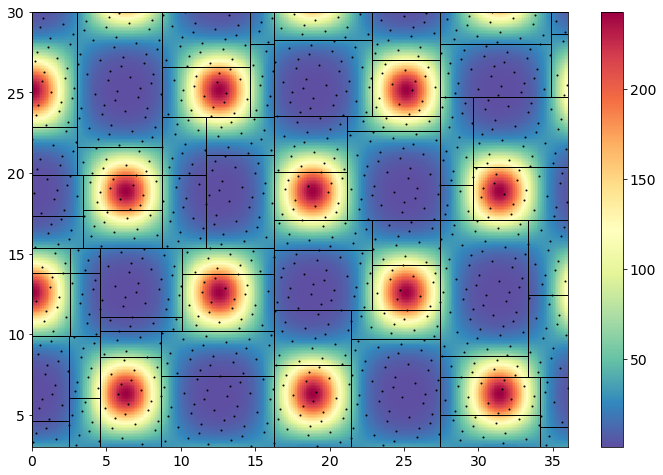

In [1175]:
pc = plt.pcolormesh(xx, yy, f, cmap='Spectral_r')

plt.colorbar(pc)

plt.scatter(x[0],x[1],c='k', s=1)

plot_tree(tree, plt.gca(), color='k')


In [464]:
tree

[1, 0.525667621954939, [0, 0.0777501027968173, None, [0, 0.8650593317946275, [0, 0.49303727549747733, [0, 0.4655068297422949, None, None], [0, 0.0, None, [1, 0.16577197817635994, [1, 0.0, None, None], None]]], [0, 1.0, None, None]]], [0, 0.4022501446559255, [0, 0.3465783967554188, None, None], [1, 0.6792664623840241, None, None]]]

## genetic opt

In [954]:
pop_size = 100

population = {}
for i in range(pop_size):
    
    rep = [0, (np.random.rand() + np.random.rand())/2, [0, (np.random.rand() + np.random.rand())/2, None, None], None]
    tree = tree_from_rep(rep)
    
    if tree.type in population:
        population[tree.type].append(tree)
    else:
        population[tree.type] = [tree]

In [955]:
fitness = {}
for key in population:
    fitness[key] = np.array([1/p.eval(x, z, bounds) for p in population[key]])
    
mean_fitness = sum([np.sum(f) for f in fitness.values()]) / pop_size

for key in fitness:
    fitness[key] /= mean_fitness

In [956]:
fitness[list(fitness)[0]]

array([1.10373943, 1.04743252, 1.09937913, 1.08596995, 0.87513753,
       1.09654146, 1.03505966, 1.00459759, 1.03609654, 0.8721408 ,
       1.0620668 , 0.9553462 , 0.95008829, 0.81374338, 0.93030537,
       0.98651956, 1.0860253 , 1.11634833, 1.04308897, 1.08635417,
       1.1015253 , 0.7460259 , 1.05177182, 1.09123563, 1.11383087,
       0.98794365, 0.87381842, 1.11597478, 1.03801186, 0.97142074,
       1.03324393, 1.06168001, 1.06741936, 0.7780614 , 1.11630475,
       1.10938747, 0.91328849, 1.0974322 , 0.8032966 , 1.00425436,
       1.01145761, 1.08728819, 0.79580411, 1.10363384, 0.99148908,
       0.95788921, 0.98829911, 1.0337462 , 1.08452596, 1.04541577,
       0.86292929, 0.93227685, 1.02263599, 0.95436951, 1.08383303,
       0.92106301, 1.07674531, 1.08520199, 1.07495041, 1.04802457,
       1.00526662, 0.95484094, 1.03369219, 1.02268089, 1.00812089,
       1.06770424, 0.95264281, 1.00025462, 1.04079004, 1.10971   ,
       1.04648687, 0.9827301 , 1.01586409, 0.94083438, 0.97530

In [957]:
np.argmax(fitness[list(fitness)[0]])

17

In [958]:
population[37].rep

KeyError: 37